# Goals

* Compare MONDO uberon terms for CellXGene and scBaseCount
* Plan:
  * Get scBaseCount datasets matching CellXGene
  * Get MONDO uberon terms for scBaseCount datasets
  * Compare MONDO uberon terms for scBaseCount and CellXGene
* Use n=10 clusters

In [1]:
import os
from pathlib import Path
import pandas as pd
import plotnine as pn
import cellxgene_census
from pypika import Query, Table, functions as fn

from SRAgent.db.connect import db_connect

In [2]:
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', 4)
pn.theme_set(pn.theme_bw())

In [3]:
# get base of github repo
base_dir = !git rev-parse --show-toplevel
base_dir = Path(base_dir[0])

In [4]:
# set environment variables
os.environ["DYNACONF"] = "prod"

# All scBaseCount diseases

In [5]:
# get metadata
meta_table = Table('srx_metadata')
star_table = Table('screcounter_star_results')
query = (
    Query.from_(meta_table)
    .inner_join(star_table)
    .on(meta_table.srx_accession == star_table.sample)
    .select(
        meta_table.entrez_id,
        meta_table.srx_accession,
        meta_table.organism,
        meta_table.disease,
        meta_table.czi_collection_id
    )
    .where(
        star_table.feature == "GeneFull_Ex50pAS"
    )
    .where(
        meta_table.lib_prep == "10x_Genomics"
    )
)

with db_connect() as conn:
    df_meta = pd.read_sql_query(str(query), conn)
df_meta

,entrez_id,srx_accession,organism,disease,czi_collection_id
0,28163394,SRX20732890,Homo sapiens,breast cancer,None
1,26948589,ERX10398458,Homo sapiens,Normal,None
...,...,...,...,...,...
61379,10000647,NRX0000647,Homo sapiens,None,None
61380,10000659,NRX0000659,Homo sapiens,None,None


In [6]:
# unique disease values
to_remove = ["unsure", "not specified", "none", "None", "none reported", "unsure", "other", "", "none specified", "Not applicable", "not applicable", "none indicated"]
df_meta_f = df_meta[df_meta["disease"].notna()]
df_meta_f = df_meta_f[~df_meta_f["disease"].isin(to_remove)]

pd.set_option("display.max_rows", 20)
df_meta_f["disease"].value_counts().to_frame().head(20)

,count
disease,
chronic myelogenous leukemia,940
normal,566
acute T cell leukemia,513
COVID-19,472
melanoma,384
Chronic Myelogenous Leukemia,298
healthy,284
glioblastoma,279
breast cancer,274


In [7]:
# distinct values
pd.set_option("display.max_rows", 4)
df_meta_f = df_meta_f[["disease"]].drop_duplicates()
print(f"Number of unique diseases: {len(df_meta_f)}")

Number of unique diseases: 12304


In [8]:
# write out disease csv
disease_file = base_dir / "data" / "diseases" / "2025-07-17_scBaseCount_unique-diseases.csv"
df_meta_f.to_csv(disease_file, index=False)
print(f"Wrote {len(df_meta_f)} records to {disease_file}")


Wrote 12304 records to /home/nickyoungblut/dev/python/scBaseCount_analysis/data/diseases/2025-07-17_scBaseCount_unique-diseases.csv


In [9]:
# output file
disease_ont_file = base_dir / "data" / "diseases" / "2025-07-17_scBaseCount_unique-diseases-with-ontology.csv"

In [10]:
# get disease ontology for all records
job = f"""#!/bin/bash
#SBATCH --job-name=get-disease-ontology
#SBATCH --output=get-disease-ontology_%j.out
#SBATCH --error=get-disease-ontology_%j.err
#SBATCH --time=2:00:00
#SBATCH --cpus-per-task=4
#SBATCH --mem=16
#SBATCH --partition=cpu_batch

# activate virtual environment
echo "Activating virtual environment"
source /home/nickyoungblut/dev/python/SRAgent/.venv/bin/activate

# Force Rich to work in non-interactive mode
export TERM=xterm
export FORCE_COLOR=1

# run script
echo "Running script"
${{HOME}}/dev/python/scBaseCount_analysis/scripts/get-disease-ontology.py \\
  --output-csv {disease_ont_file} \\
  --limit 10 \\
  --force-restart \\
  --checkpoint-freq 5 \\
  {disease_file}
"""

job_file = "get-disease-ontology.sh"
with open(job_file, "w") as f:
    f.write(job)

print(f"Wrote job to {job_file}")
print(job)

Wrote job to get-disease-ontology.sh
#!/bin/bash
#SBATCH --job-name=get-disease-ontology
#SBATCH --output=get-disease-ontology_%j.out
#SBATCH --error=get-disease-ontology_%j.err
#SBATCH --time=2:00:00
#SBATCH --cpus-per-task=4
#SBATCH --mem=16
#SBATCH --partition=cpu_batch

# activate virtual environment
echo "Activating virtual environment"
source /home/nickyoungblut/dev/python/SRAgent/.venv/bin/activate

# Force Rich to work in non-interactive mode
export TERM=xterm
export FORCE_COLOR=1

# run script
echo "Running script"
${HOME}/dev/python/scBaseCount_analysis/scripts/get-disease-ontology.py \
  --output-csv /home/nickyoungblut/dev/python/scBaseCount_analysis/data/diseases/2025-07-17_scBaseCount_unique-diseases-with-ontology.csv \
  --limit 10 \
  --force-restart \
  --checkpoint-freq 5 \
  /home/nickyoungblut/dev/python/scBaseCount_analysis/data/diseases/2025-07-17_scBaseCount_unique-diseases.csv



In [11]:
# sbatch
#!sbatch {job_file}

In [12]:
!ls -thlc get-disease-ontology*

-rw-r--r-- 1 nickyoungblut multiomics 877 Jul 23 17:05 get-disease-ontology.sh
-rw-r--r-- 1 nickyoungblut multiomics 78K Jul 19 10:08 get-disease-ontology.log


In [13]:
!tail -n 20 get-disease-ontology.log

Chunk completed: 20/20 successful
Checkpoint saved (12220 total records processed)
Processing chunk 612 (records 12221-12240)
Chunk completed: 20/20 successful
Checkpoint saved (12240 total records processed)
Processing chunk 613 (records 12241-12260)
Chunk completed: 20/20 successful
Checkpoint saved (12260 total records processed)
Processing chunk 614 (records 12261-12280)
Chunk completed: 20/20 successful
Checkpoint saved (12280 total records processed)
Processing chunk 615 (records 12281-12300)
Chunk completed: 20/20 successful
Checkpoint saved (12300 total records processed)
Processing chunk 616 (records 12301-12302)
Chunk completed: 2/2 successful
Checkpoint saved (12302 total records processed)
  Processing diseases... ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 100% 0:00:00
Success! Wrote 12302 records to 
/home/nickyoungblut/dev/python/scBaseCount_analysis/data/diseases/2025-07-17_scBaseCount_unique-diseases-with-ontology.csv


In [14]:
# read in disease ontology file
df_disease_ont = pd.read_csv(disease_ont_file)
df_disease_ont

,disease,disease_ontology_term_id
0,breast cancer,MONDO:0007254
1,Normal,NaN
...,...,...
12300,none (healthy adult deceased donors),NaN
12301,none; healthy young vs aged mice,NaN


In [15]:
# number of non-NaN records
df_disease_ont[df_disease_ont["disease_ontology_term_id"].notna()].shape[0]

9552

In [16]:
# explode disease ontology term id
df_disease_ont_sum = (
    df_disease_ont[df_disease_ont["disease_ontology_term_id"].notna()]
    .assign(disease_ontology_term_id=lambda x: x["disease_ontology_term_id"].str.split(";"))
    .explode("disease_ontology_term_id")["disease_ontology_term_id"].value_counts()
    .reset_index()
    .rename(columns={"disease_ontology_term_id" : "node_id", "count": "node_abundance"})
)
df_disease_ont_sum

,node_id,node_abundance
0,MONDO:0100096,368
1,MONDO:0004975,137
...,...,...
2231,MONDO:0001687,1
2232,MONDO:0975870,1


In [17]:
# write to file
disease_ont_file = base_dir / "data" / "diseases" / "2025-07-17_scBaseCount_unique-diseases-with-ontology_sum.csv"
df_disease_ont_sum.to_csv(disease_ont_file, index=False)
print(f"Wrote {len(df_disease_ont_sum)} records to {disease_ont_file}")

Wrote 2233 records to /home/nickyoungblut/dev/python/scBaseCount_analysis/data/diseases/2025-07-17_scBaseCount_unique-diseases-with-ontology_sum.csv


In [24]:
# Run the job
clst_file = Path(base_dir / "data/diseases/2025-07-23_scBaseCount_unique-diseases-with-ontology_sum_clst-n10.tsv")

job = f"""#!/bin/bash
#SBATCH --job-name=mondo
#SBATCH --output=logs/mondo_%j.out
#SBATCH --error=logs/mondo_%j.err
#SBATCH --time=8:00:00
#SBATCH --cpus-per-task=8
#SBATCH --mem=32G
#SBATCH --partition=cpu_batch

conda activate ontology

setwd {base_dir}

./scripts/cluster-ontology.py \\
    -o {clst_file} \\
    --n-clusters 10 \\
    --prune-nodes \\
    tmp/mondo.owl \\
    data/diseases/2025-07-17_scBaseCount_unique-diseases-with-ontology_sum.csv
"""
slurm_file = Path("tmp/mondo_owl_cluster_n10.sh")
slurm_file.parent.mkdir(parents=True, exist_ok=True)
slurm_file.write_text(job)
print(job)

#!/bin/bash
#SBATCH --job-name=mondo
#SBATCH --output=logs/mondo_%j.out
#SBATCH --error=logs/mondo_%j.err
#SBATCH --time=8:00:00
#SBATCH --cpus-per-task=8
#SBATCH --mem=32G
#SBATCH --partition=cpu_batch

conda activate ontology

setwd /home/nickyoungblut/dev/python/scBaseCount_analysis

./scripts/cluster-ontology.py \
    -o /home/nickyoungblut/dev/python/scBaseCount_analysis/data/diseases/2025-07-23_scBaseCount_unique-diseases-with-ontology_sum_clst-n10.tsv \
    --n-clusters 10 \
    --prune-nodes \
    tmp/mondo.owl \
    data/diseases/2025-07-17_scBaseCount_unique-diseases-with-ontology_sum.csv



In [19]:
# submit job
#!sbatch tmp/mondo_owl_cluster_n10.sh

In [56]:
# read in output
pd.set_option("display.max_colwidth", 30)
pd.set_option("display.max_rows", 4)
df_clst = pd.read_csv(clst_file, sep="\t")
df_clst.sort_values("abundance", ascending=False)

,node_id,node_name,cluster_id,cluster_root_labels,abundance,definition
1360,MONDO:0100096,COVID-19,3,polyomavirus infectious di...,368.0,A disease caused by infect...
0,MONDO:0004975,Alzheimer disease,0,post-traumatic stress diso...,137.0,"A progressive, neurodegene..."
...,...,...,...,...,...,...
2086,MONDO:0018875,Li-Fraumeni syndrome,7,mosaic variegated aneuploi...,1.0,A rare cancer predispositi...
2087,MONDO:0003582,hereditary breast ovarian ...,7,mosaic variegated aneuploi...,1.0,An autosomal dominant inhe...


In [57]:
# distinct cluster_root_labels
df_clst_roots = df_clst.groupby(["cluster_id", "cluster_root_labels"]).agg({"abundance": "sum"}).reset_index()
df_clst_roots

,cluster_id,cluster_root_labels,abundance
0,0,post-traumatic stress diso...,6513.0
1,1,femoral neck fracture:ulna...,90.0
...,...,...,...
8,8,intellectual developmental...,13.0
9,9,neutral lipid storage dise...,381.0


In [58]:
# unique cluster_root_labels

df_clst_roots["cluster_root_labels"] = df_clst_roots["cluster_root_labels"].str.split(":")
df_clst_roots = df_clst_roots.explode("cluster_root_labels")

pd.set_option("display.max_colwidth", 200)
pd.set_option("display.max_rows", 50)
df_clst_roots["cluster_id"].value_counts()

cluster_id
0    895
5    201
3    133
6    129
9     60
7     27
1      8
2      7
4      5
8      2
Name: count, dtype: int64

In [21]:
# max abundance per cluster_id
pd.set_option("display.max_rows", 10)
df_clst.groupby("cluster_id").agg({"abundance": "max"})

,abundance
cluster_id,
0,100.0
1,7.0
2,368.0
3,32.0
4,61.0
5,137.0
6,8.0
7,64.0
8,52.0


In [22]:
# most abundant node_id per cluster_id
df_clst_top = df_clst.groupby("cluster_id")["abundance"].idxmax().reset_index(name="node_id")
df_clst_top

,cluster_id,node_id
0,0,0
1,1,1078
2,2,1086
3,3,1279
4,4,1291
5,5,1302
6,6,1624
7,7,1628
8,8,1709
9,9,1897


In [23]:
# most abundant node_id per cluster_id
pd.set_option("display.max_rows", 10)
df_clst.loc[df_clst_top["node_id"]]

,node_id,node_name,cluster_id,abundance,definition
0,MONDO:0004992,cancer,0,100.0,"A tumor composed of atypical neoplastic, often..."
1078,MONDO:0100182,"schizophrenia, susceptibility to",1,7.0,An inherited susceptibility or predisposition ...
1086,MONDO:0100096,COVID-19,2,368.0,A disease caused by infection with severe acut...
1279,MONDO:0005203,ischemia reperfusion injury,3,32.0,"Adverse functional, metabolic, or structural c..."
1291,MONDO:0025483,"mammary neoplasms, animal",4,61.0,Tumors or cancer of the mammary gland in anima...
1302,MONDO:0004975,Alzheimer disease,5,137.0,"A progressive, neurodegenerative disease chara..."
1624,MONDO:0014017,intellectual developmental disorder with autis...,6,8.0,NaN
1628,MONDO:0005015,diabetes mellitus,7,64.0,A metabolic disorder characterized by abnormal...
1709,MONDO:0005068,myocardial infarction,8,52.0,"Gross necrosis of the myocardium, as a result ..."
1897,MONDO:0002771,pulmonary fibrosis,9,59.0,Chronic progressive interstitial lung disorder...


In [24]:
# top N most abundant node_ids per cluster_id
pd.set_option("display.max_rows", 50)
df_clst_top = df_clst.groupby("cluster_id", group_keys=False).apply(
    lambda x: x.sort_values("abundance", ascending=False).head(5)
)
df_clst_top 

/tmp/ipykernel_2307609/789934153.py:3: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.


,node_id,node_name,cluster_id,abundance,definition
0,MONDO:0004992,cancer,0,100.0,"A tumor composed of atypical neoplastic, often..."
1,MONDO:0011122,obesity disorder,0,98.0,A disorder involving an excessive amount of bo...
2,MONDO:0007254,breast cancer,0,95.0,A primary or metastatic malignant neoplasm inv...
3,MONDO:0005134,experimental autoimmune encephalomyelitis,0,89.0,An autoimmune demyelinating disease of the cen...
4,MONDO:0005105,melanoma,0,86.0,"A malignant, usually aggressive tumor composed..."
1078,MONDO:0100182,"schizophrenia, susceptibility to",1,7.0,An inherited susceptibility or predisposition ...
1079,MONDO:0021024,"malaria, susceptibility to",1,6.0,NaN
1080,MONDO:0020573,inherited disease susceptibility,1,3.0,A latent susceptibility to disease at the gene...
1081,MONDO:1040030,"GBA1-related Parkinson disease, susceptibility",1,2.0,A susceptibility or predisposition to Parkinso...
1082,MONDO:0011520,"systemic lupus erythematosus, susceptibility t...",1,2.0,NaN


In [25]:
# save the table
outfile = base_dir / "data" / "diseases" / "2025-07-22_scBaseCount_unique-diseases-with-ontology_sum_clst-n10_top5.csv"
df_clst_top.to_csv(outfile, index=False)
print(f"Wrote {len(df_clst_top)} records to {outfile}")

Wrote 49 records to /home/nickyoungblut/dev/python/scBaseCount_analysis/data/diseases/2025-07-22_scBaseCount_unique-diseases-with-ontology_sum_clst-n10_top5.csv


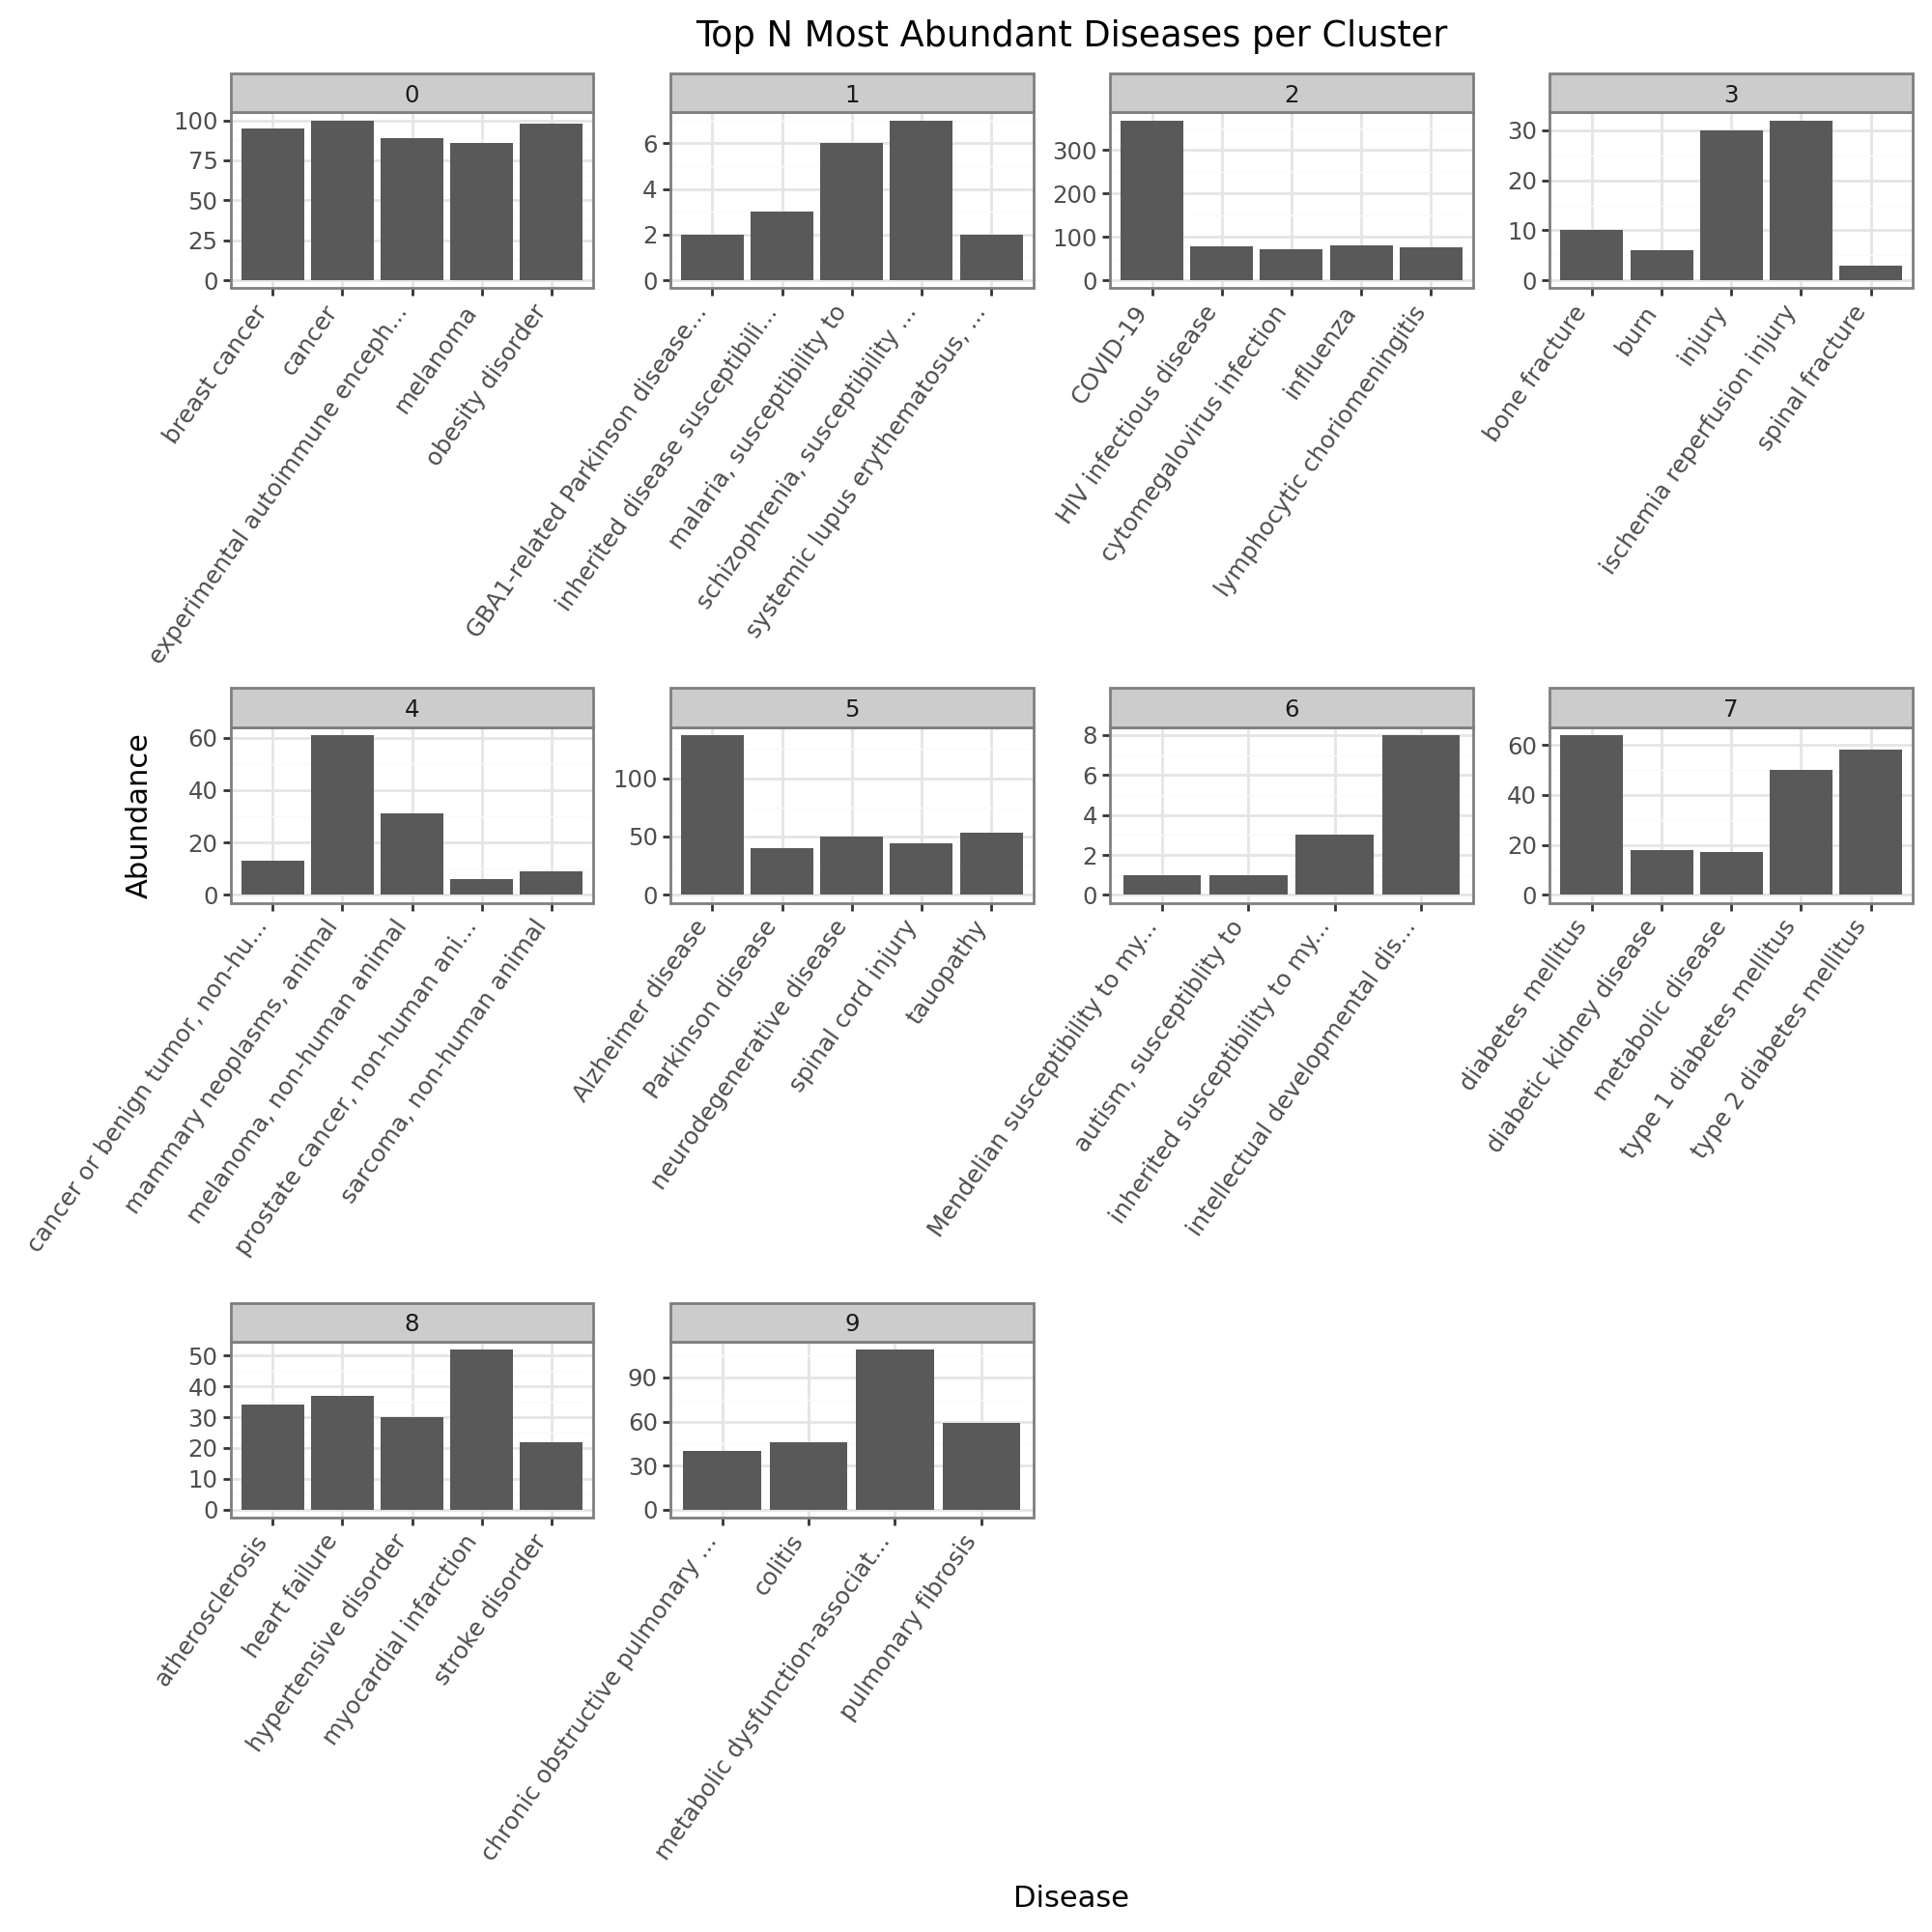

In [25]:
# plot the top N most abundant node_ids per cluster_id
df = df_clst_top.copy()
df["node_name"] = df["node_name"].apply(lambda x: x[:30] + "..." if len(x) > 30 else x)

p = (
    pn.ggplot(df, pn.aes(x="node_name", y="abundance"))
    + pn.geom_bar(stat="identity")
    + pn.facet_wrap("~cluster_id", scales="free")
    + pn.labs(
        x="Disease",
        y="Abundance",
        title="Top N Most Abundant Diseases per Cluster"
    )
    + pn.theme(
        figure_size=(10, 10),
        axis_text_x=pn.element_text(angle=55, hjust=1),
    )
)
p

In [26]:
def df_to_yaml(df: pd.DataFrame) -> str:
    """
    Convert DataFrame to YAML format with single-letter column abbreviations.
    Args:
        df: pandas DataFrame
    Returns:
        str: YAML string
    """
    if df.empty:
        return "No records found"
    
    result = []
    
    # Create column abbreviations (A, B, C, ..., Z, AA, AB, etc.)
    def get_column_abbrev(index):
        """Generate Excel-style column abbreviations."""
        result = ""
        while index >= 0:
            result = chr(ord('A') + (index % 26)) + result
            index = index // 26 - 1
        return result
    
    # Create column mapping
    column_map = {}
    for i, col in enumerate(df.columns):
        column_map[col] = get_column_abbrev(i)
    
    # Add column naming key
    result.append("Column naming key (name: abbreviation):")
    for col, abbrev in column_map.items():
        result.append(f"  - {col}: {abbrev}")
    result.append("")  # Empty line for separation
    
    # Add data using abbreviations
    for i, row in df.iterrows():
        result.append(f"Record {i + 1}:")
        for col, val in row.items():
            abbrev = column_map[col]
            result.append(f"  {abbrev}: {val}")
        result.append("")  # Empty line between records
    
    return "\n".join(result)

In [27]:
# top N most abundant node_ids per cluster_id
pd.set_option("display.max_rows", 100)
df_clst_top = df_clst.groupby("cluster_id", group_keys=False).apply(
    lambda x: x.sort_values("abundance", ascending=False).head(10)
)


# save the table
x = df_to_yaml(df_clst_top[["cluster_id", "node_name", "node_id"]].reset_index(drop=True))
outfile = base_dir / "data" / "diseases" / "2025-07-22_scBaseCount_unique-diseases-with-ontology_sum_clst-n10_top10.yaml"
with open(outfile, "w") as f:
    f.write(x)
print(f"Wrote {outfile}")

Wrote /home/nickyoungblut/dev/python/scBaseCount_analysis/data/diseases/2025-07-22_scBaseCount_unique-diseases-with-ontology_sum_clst-n10_top10.yaml


/tmp/ipykernel_324804/4213135887.py:3: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.


In [28]:
# pandas dataframe of cluster labels
df_clst_labels = pd.DataFrame({
    'cluster_id': [0, 1, 2, 3, 4, 5, 6, 7, 8, 9],
    'cluster_name': [
        'Cancer and Neoplasms',
        'Genetic Disease Susceptibilities',
        'Infectious Diseases',
        'Physical Injuries and Trauma',
        'Veterinary and Animal Diseases',
        'Neurological and Neurodegenerative Diseases',
        'Developmental and Immunodeficiency Disorders',
        'Metabolic and Diabetes-Related Diseases',
        'Cardiovascular Diseases',
        'Inflammatory and Respiratory Diseases'
    ]
})
df_clst_labels

,cluster_id,cluster_name
0,0,Cancer and Neoplasms
1,1,Genetic Disease Susceptibilities
2,2,Infectious Diseases
3,3,Physical Injuries and Trauma
4,4,Veterinary and Animal Diseases
5,5,Neurological and Neurodegenerative Diseases
6,6,Developmental and Immunodeficiency Disorders
7,7,Metabolic and Diabetes-Related Diseases
8,8,Cardiovascular Diseases
9,9,Inflammatory and Respiratory Diseases


In [29]:
# Expanding back to all scBaseCount records
pd.set_option("display.max_rows", 4)
df_clst_all = (
    df_clst_labels
    .merge(df_clst, on="cluster_id", how="inner")
    .merge(df_disease_ont, left_on="node_id", right_on="disease_ontology_term_id", how="inner")
    .merge(df_meta, on="disease", how="right")
    .rename(columns={"cluster_id": "mondo_cluster_id", "disease_ontology_term_id": "mondo_node_id", "cluster_name": "mondo_cluster_name"})
)[["entrez_id", "srx_accession", "organism", "disease", "mondo_node_id", "mondo_cluster_id", "mondo_cluster_name"]]
df_clst_all

,entrez_id,srx_accession,organism,disease,mondo_node_id,mondo_cluster_id,mondo_cluster_name
0,28163394,SRX20732890,Homo sapiens,breast cancer,MONDO:0007254,0.0,Cancer and Neoplasms
1,26948589,ERX10398458,Homo sapiens,Normal,NaN,NaN,NaN
...,...,...,...,...,...,...,...
61379,10000170,NRX0000170,Homo sapiens,None,NaN,NaN,NaN
61380,10000171,NRX0000171,Homo sapiens,None,NaN,NaN,NaN


In [30]:
# use "disease" free text values for Healthy
healthy_values = ["healthy", "normal", "control", "wild-type", "wild type", "wildtype", "none", "not reported", "not specified"]
df_clst_all["mondo_cluster_id"] = df_clst_all.apply(lambda x: 10 if x["disease"] and any(value in x["disease"].lower() for value in healthy_values) else x["mondo_cluster_id"], axis=1)
df_clst_all["mondo_cluster_name"] = df_clst_all.apply(lambda x: "Healthy" if x["disease"] and any(value in x["disease"].lower() for value in healthy_values) else x["mondo_cluster_name"], axis=1)
df_clst_all

,entrez_id,srx_accession,organism,disease,mondo_node_id,mondo_cluster_id,mondo_cluster_name
0,28163394,SRX20732890,Homo sapiens,breast cancer,MONDO:0007254,0.0,Cancer and Neoplasms
1,26948589,ERX10398458,Homo sapiens,Normal,NaN,10.0,Healthy
...,...,...,...,...,...,...,...
61379,10000170,NRX0000170,Homo sapiens,None,NaN,NaN,NaN
61380,10000171,NRX0000171,Homo sapiens,None,NaN,NaN,NaN


In [32]:
# filter NaN for mondo_cluster_id
df_clst_all = df_clst_all[df_clst_all["mondo_cluster_id"].notna()].reset_index(drop=True)
df_clst_all

,entrez_id,srx_accession,organism,disease,mondo_node_id,mondo_cluster_id,mondo_cluster_name
0,28163394,SRX20732890,Homo sapiens,breast cancer,MONDO:0007254,0.0,Cancer and Neoplasms
1,26948589,ERX10398458,Homo sapiens,Normal,NaN,10.0,Healthy
...,...,...,...,...,...,...,...
41269,14055351,SRX10579581,Mus musculus,none reported,NaN,10.0,Healthy
41270,21270690,ERX8792214,Homo sapiens,None (healthy donors),NaN,10.0,Healthy


In [33]:
# check for duplicates
pd.set_option("display.max_rows", 4)
df_clst_all.duplicated(subset=["srx_accession"]).sum()

0

In [34]:
# organism counts
pd.set_option("display.max_rows", 30)
df_clst_all["organism"].value_counts()

organism
Homo sapiens               23303
Mus musculus               15473
Macaca mulatta               663
Danio rerio                  480
Drosophila melanogaster      251
Sus scrofa                   196
Rattus norvegicus            153
Bos taurus                   108
Arabidopsis thaliana         104
Ovis aries                    94
Heterocephalus glaber         89
Gallus gallus                 88
Callithrix jacchus            66
Mesocricetus auratus          42
Caenorhabditis elegans        37
Oryctolagus cuniculus         26
Pan troglodytes               20
Chlorocebus aethiops          17
Oryza sativa                  15
Zea mays                      14
Equus caballus                11
Schistosoma mansoni            8
Solanum lycopersicum           4
Monodelphis domestica          4
Gasterosteus aculeatus         2
Gorilla gorilla                2
Taeniopygia guttata            1
Name: count, dtype: int64

In [35]:
# save the table
pd.set_option("display.max_rows", 4)
outfile = base_dir / "data" / "diseases" / "2025-07-22_scBaseCount_unique-diseases-with-ontology_sum_clst-n10_records.csv"
df_clst_all.to_csv(outfile, index=False)
print(f"Wrote {len(df_clst_all)} records to {outfile}")

Wrote 41271 records to /home/nickyoungblut/dev/python/scBaseCount_analysis/data/diseases/2025-07-22_scBaseCount_unique-diseases-with-ontology_sum_clst-n10_records.csv


# session info

In [37]:
!conda list

# packages in environment at /home/nickyoungblut/miniforge3/envs/SRAgent_nb:
#
# Name                    Version                   Build  Channel
_libgcc_mutex             0.1                 conda_forge    conda-forge
_openmp_mutex             4.5                       2_gnu    conda-forge
_python_abi3_support      1.0                  hd8ed1ab_2    conda-forge
aiobotocore               2.23.0             pyhd8ed1ab_0    conda-forge
aiohappyeyeballs          2.6.1              pyhd8ed1ab_0    conda-forge
aiohttp                   3.11.14                  pypi_0    pypi
aioitertools              0.12.0             pyhd8ed1ab_1    conda-forge
aiosignal                 1.3.2              pyhd8ed1ab_0    conda-forge
anndata                   0.11.4             pyhd8ed1ab_0    conda-forge
annotated-types           0.7.0                    pypi_0    pypi
anthropic                 0.57.1                   pypi_0    pypi
anyio                     4.9.0                    pypi_0    pypi
appdir